In [ ]:
!pip install transformers[torch]
!pip install -U datasets
!pip install -U transformers
!pip install -U accelerate
!pip freeze | grep accelerate
#Must use GPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-1-59960e912681>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap('tab20', len(counts))(i) for i in range(len(counts))]
<ipython-input-1-59960e912681>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pct = 100 * counts[i] / total


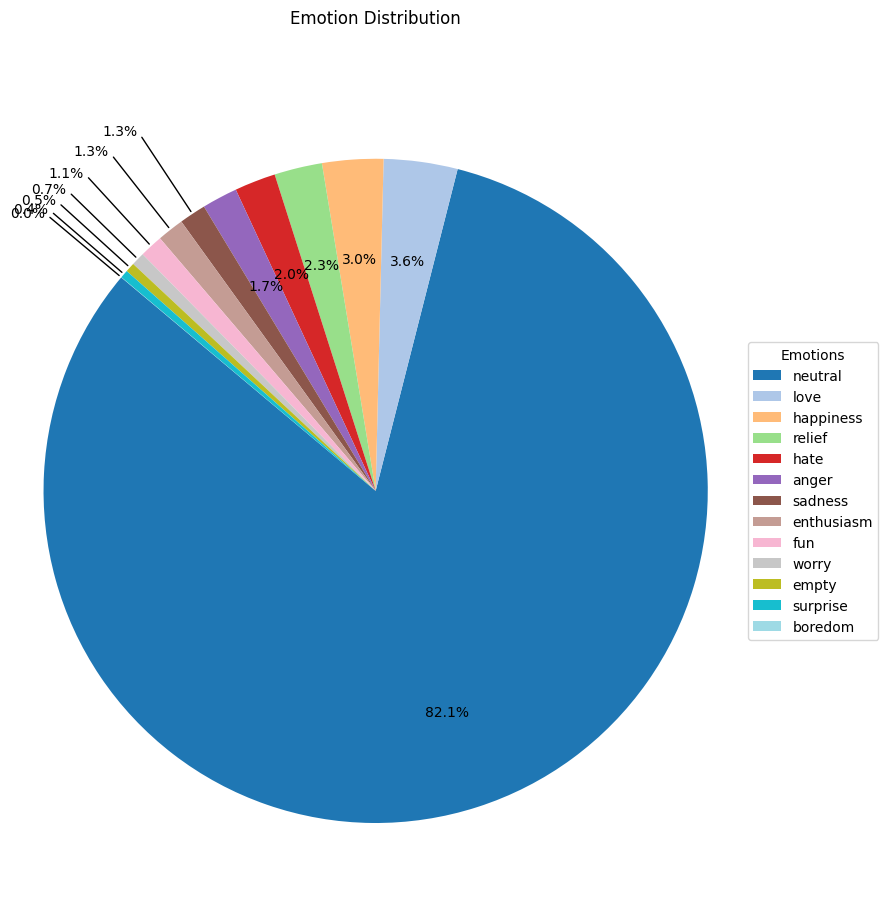

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os.path
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Load the emotion analysis dataset
dataset_file_name = os.path.join('drive','MyDrive','Colab Notebooks',"emotion_sentiment_dataset.csv")
dataset = pd.read_csv(dataset_file_name)
dataset = dataset.head(10000)

###===== Part 1.1 =======
#Draw a pie plot using matplotlib of all the possible emotions

# Data prep
counts = dataset['Emotion'].value_counts()
total = counts.sum()
colors = [cm.get_cmap('tab20', len(counts))(i) for i in range(len(counts))]

# Plot
fig, ax = plt.subplots(figsize=(9, 9))
wedges, _ = ax.pie(counts, startangle=140, colors=colors, radius=1.0)

# Add percent labels: inline for big slices, arrows for small ones
for i, w in enumerate(wedges):
    pct = 100 * counts[i] / total
    ang = (w.theta2 + w.theta1) / 2
    x, y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    if pct < 1.6:
        ax.annotate(f"{pct:.1f}%", xy=(x, y), xytext=(1.3*x, 1.3*y),
                    ha='left' if x > 0 else 'right', va='center',
                    arrowprops=dict(arrowstyle='-', connectionstyle=f"angle,angleA=0,angleB={ang}"),
                    fontsize=10)
    else:
        ax.text(0.7*x, 0.7*y, f"{pct:.1f}%", ha='center', va='center', fontsize=10)

# Legend and title
ax.legend(wedges, counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Emotion Distribution', y=1.08)
ax.axis('equal')
plt.tight_layout()
plt.show()
###=====

In [ ]:
# Map emotions to 'neutral' and 'non-neutral'
dataset['Emotion'] = dataset['Emotion'].apply(lambda x: 0 if x == 'neutral' else 1)

In [ ]:
import random
import pandas as pd
random.seed(42)
dataset['Type'] = ['Train' if random.random() < 0.8 else 'Test' for _ in dataset['Emotion']]

# Split dataset into train and test sets
train_texts = dataset[dataset['Type'] == "Train" ]['text']
train_labels = dataset[dataset['Type'] == "Train" ]['Emotion']

test_texts = dataset[dataset['Type'] == "Test" ]['text']
test_labels = dataset[dataset['Type'] == "Test" ]['Emotion']

In [ ]:
import numpy as np
percent_of_minority_train = np.mean(train_labels)*100
percent_of_minority_test = np.mean(test_labels)*100
print(f" {percent_of_minority_train:.2f}% in training set" )
print(f" {percent_of_minority_test:.2f}% in testing set" )

 17.71% in training set
 18.49% in testing set


In [ ]:
# Prepare the dataset for the transformer
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': train_texts,
    'label': train_labels
}))
test_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': test_texts,
    'label': test_labels
}))

# Load pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Function to tokenize the dataset
def tokenize_data(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1969 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    logging_dir='./logs',
    do_eval=True,
    eval_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.127400,0.084915
2,0.061900,0.057636
3,0.018100,0.054349
4,0.012200,0.051667
5,0.004900,0.060427


{'eval_loss': 0.06042655557394028, 'eval_runtime': 28.2545, 'eval_samples_per_second': 69.688, 'eval_steps_per_second': 8.742, 'epoch': 5.0}


In [ ]:
# model_path = '/content/drive/MyDrive/Colab Notebooks/emotion_model/'
# trainer.save_model(model_path)
# tokenizer.save_pretrained(model_path)

# import json
# # Convert to plain Python int/str types
# label2id_fixed = {str(k): int(v) for k, v in label2id.items()}
# id2label_fixed = {int(k): str(v) for k, v in id2label.items()}

# # Save
# label_path = '/content/drive/MyDrive/Colab Notebooks/emotion_model/label_mappings.json'
# with open(label_path, 'w') as f:
#     json.dump({'label2id': label2id_fixed, 'id2label': id2label_fixed}, f)

('/content/drive/MyDrive/Colab Notebooks/emotion_model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/emotion_model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/emotion_model/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/emotion_model/added_tokens.json')

Training Precision: 0.9996, Training Recall: 0.9996
Testing Precision: 0.9929, Testing Recall: 0.9929


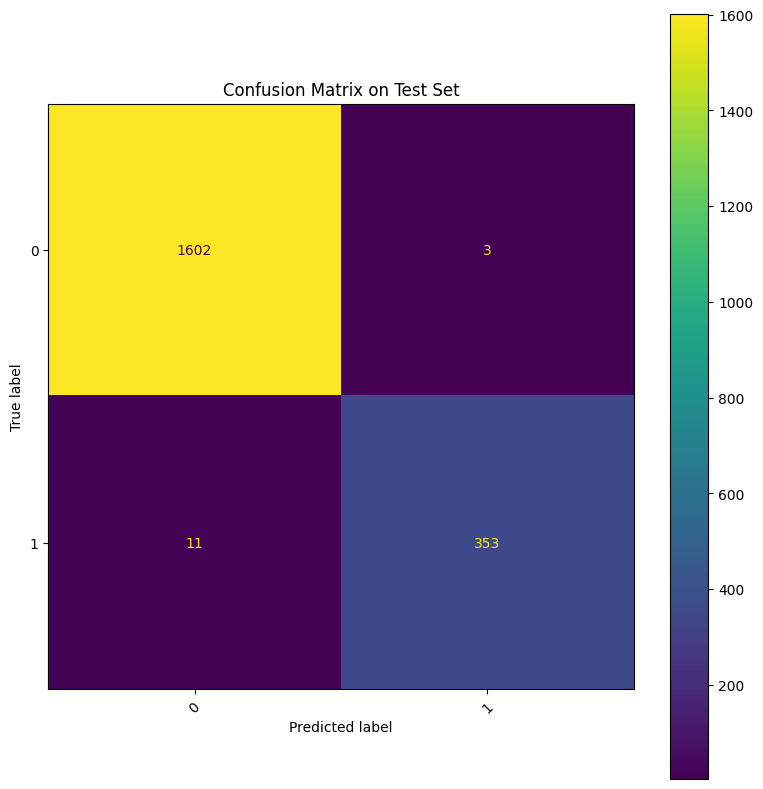

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

###===== Part 1.3 =======
## Write a code that calculates the precision and recall on the training and testing dataset
# Function to calculate precision and recall
def compute_precision_recall(predictions, references):
    return (
        precision_score(references, predictions, average='weighted'),
        recall_score(references, predictions, average='weighted')
    )
###===== End of part 1.3 =======


# Predict outputs for the training dataset
train_output = trainer.predict(train_dataset)
train_predictions = train_output.predictions.argmax(-1)
train_references = train_output.label_ids

# Predict outputs for the testing dataset
test_output = trainer.predict(test_dataset)
test_predictions = test_output.predictions.argmax(-1)
test_references = test_output.label_ids

# Compute precision and recall for the training dataset
train_precision, train_recall = compute_precision_recall(train_predictions, train_references)
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")

# Compute precision and recall for the testing dataset
test_precision, test_recall = compute_precision_recall(test_predictions, test_references)
print(f"Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}")


# Compute and plot the confusion matrix for test data
cm = confusion_matrix(test_references, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(len(id2label))])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


In [ ]:
## ==== Part 1.4 ==============

# Adjust paths based on your actual Drive folder names
emotion_path = '/content/drive/MyDrive/Colab Notebooks/emotions_dataset/text.csv'
sentiment_path = '/content/drive/MyDrive/Colab Notebooks/sentiment_analysis_dataset/train.csv'

emotion_df = pd.read_csv(emotion_path)
sentiment_df = pd.read_csv(sentiment_path, encoding='ISO-8859-1')

# Map "neutral" to 0, everything else to 1
sentiment_df['binary_label'] = sentiment_df['sentiment'].str.lower().apply(lambda x: 0 if x == 'neutral' else 1)
# All emotions are non-neutral
emotion_df['binary_label'] = 1

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Sentiment Precision: 0.6708, Sentiment Recall: 0.4990
Emotion Precision:   1.0000, Emotion Recall:   0.2130


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


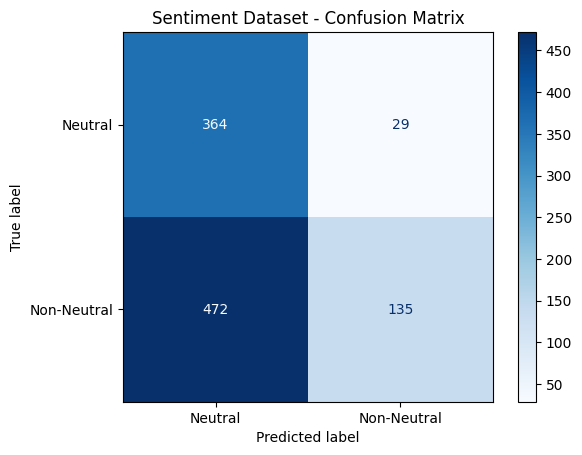

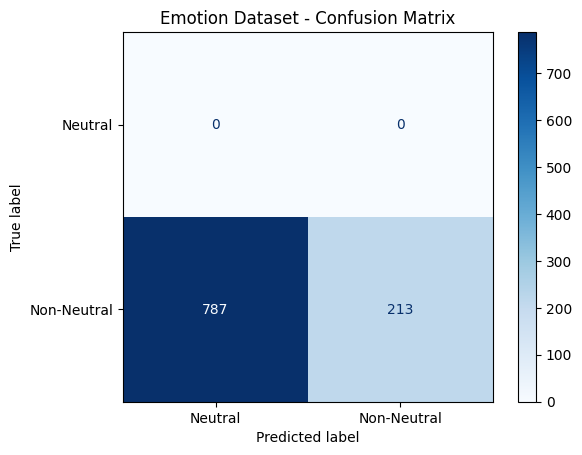

In [ ]:
## ==== Part 1.5 ==============
# Assuming that all the data in the additional datasets is test data, what is the performance of the model on each of the datasets, without retraining the classifier?


# === 1. Reduce datasets to 1K instances ===
sentiment_test_df = sentiment_df[['text', 'binary_label']].dropna().sample(n=1000, random_state=42)
emotion_test_df = emotion_df[['text', 'binary_label']].dropna().sample(n=1000, random_state=42)

# === 2. Convert to HuggingFace Datasets ===
sentiment_dataset = Dataset.from_pandas(sentiment_test_df.rename(columns={'binary_label': 'label'}))
emotion_dataset = Dataset.from_pandas(emotion_test_df.rename(columns={'binary_label': 'label'}))

# === 3. Tokenize ===
def tokenize_binary(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

sentiment_dataset = sentiment_dataset.map(tokenize_binary, batched=True)
emotion_dataset = emotion_dataset.map(tokenize_binary, batched=True)

sentiment_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotion_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# === 4. Predict ===
sentiment_preds = trainer.predict(sentiment_dataset)
emotion_preds = trainer.predict(emotion_dataset)

sentiment_y_pred = np.argmax(sentiment_preds.predictions, axis=1)
sentiment_y_true = sentiment_preds.label_ids

emotion_y_pred = np.argmax(emotion_preds.predictions, axis=1)
emotion_y_true = emotion_preds.label_ids

# === 5. Compute precision and recall ===
s_prec, s_rec = compute_precision_recall(sentiment_y_pred, sentiment_y_true)
e_prec, e_rec = compute_precision_recall(emotion_y_pred, emotion_y_true)

print(f"Sentiment Precision: {s_prec:.4f}, Sentiment Recall: {s_rec:.4f}")
print(f"Emotion Precision:   {e_prec:.4f}, Emotion Recall:   {e_rec:.4f}")

# === 6. Confusion Matrices ===
cm_s = confusion_matrix(sentiment_y_true, sentiment_y_pred)
disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=['Neutral', 'Non-Neutral'])
disp_s.plot(cmap='Blues')
plt.title("Sentiment Dataset - Confusion Matrix")
plt.show()

cm_e = confusion_matrix(emotion_y_true, emotion_y_pred)
disp_e = ConfusionMatrixDisplay(confusion_matrix=cm_e, display_labels=['Neutral', 'Non-Neutral'])
disp_e.plot(cmap='Blues')
plt.title("Emotion Dataset - Confusion Matrix")
plt.show()
